## Эксперименты для проекта
# Regularized nonlinear acceleration

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

%matplotlib inline
sns.set(context='talk', style='white')

## Реализация алгоритмов ускорения:

Все представленные ниже алгоритмы принимают последовательность $x_0,\ldots,x_{k+1}$.

1) Anderson acceleration:

In [2]:
def anderson(X, *args, **kwargs):
    k = 5
    if len(X) < k + 2:
        return X[-1]
    
    X = np.array(X[-(k + 1):]).T
    R = (X[:, 1:] - X[:, :-1])
    z = np.linalg.solve(R.T @ R, np.ones(R.shape[1]))
    c = z / z.sum()
    return X[:, :-1] @ c

2) Adaptive Regularized Nonlinear Acceleration:

In [3]:
def arna(X, f, lmin=0.1, lmax=10**4):
    k = 5
    if len(X) < k + 2:
        return X[-1]
    
    ls = np.exp(np.linspace(np.log(lmin), np.log(lmax), k))
    
    X = np.array(X[-(k + 2):]).T
    R = (X[:, 1:] - X[:, :-1])
    M = R.T @ R
    M = M / np.linalg.norm(M)
    
    x_extr = []
    for lambd in ls:
        try:
            z = np.linalg.solve(M + lambd, np.ones(R.shape[1]))
        except:
            continue
        c = z / z.sum()
        x_extr.append(X[:, :-1] @ c)
        
    if len(x_extr) == 0:
        raise Exception()

    fs = np.array([f(x) for x in x_extr])
    x_opt = x_extr[fs.argmin()]
    
    x0 = X[:, -(k + 1)]
    def F(t):
        return f(x0 + t * (x_opt - x0))

    t = 1
    while F(2 * t) < F(t):
        t *= 2
    
    return x0 + t * (x_opt - x0)

## Сходимость аналогична методу Нестерова

Получим график для пункта 3.1 отчёта.

Сгенерируем плохо обусловленную задачу (код частично взят отсюда: [amkatrutsa](https://github.com/amkatrutsa/liboptpy/blob/master/examples/demo_unconstr_solvers.ipynb)):

Condition number = 1000.0000000005443


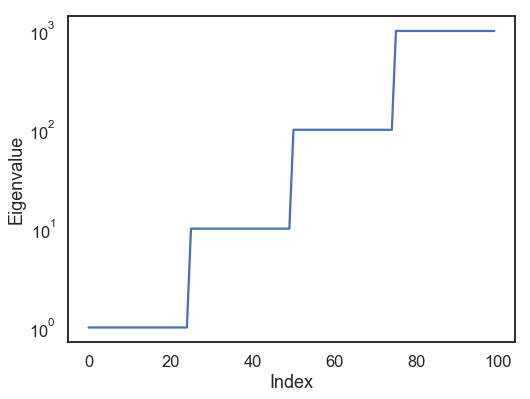

In [4]:
n = 100
A = np.diagflat([np.ones(n//4), 10 * np.ones(n//4), 100*np.ones(n//4), 1000* np.ones(n//4)])
U = np.random.rand(n, n)
Q, _ = np.linalg.qr(U)
A = Q.dot(A).dot(Q.T)
A = (A + A.T) * 0.5
b = np.random.randn(n)
eig_vals = np.linalg.eigvalsh(A)
print("Condition number = {}".format(max(eig_vals) / min(eig_vals)))
plt.figure(figsize=(8,6))
plt.semilogy(np.sort(eig_vals))
plt.xlabel("Index")
plt.ylabel("Eigenvalue");

In [5]:
f1 = lambda x: 0.5 * x.dot(A.dot(x)) - b.dot(x)
grad_f1 = lambda x: A.dot(x) - b
x01 = np.zeros(n)

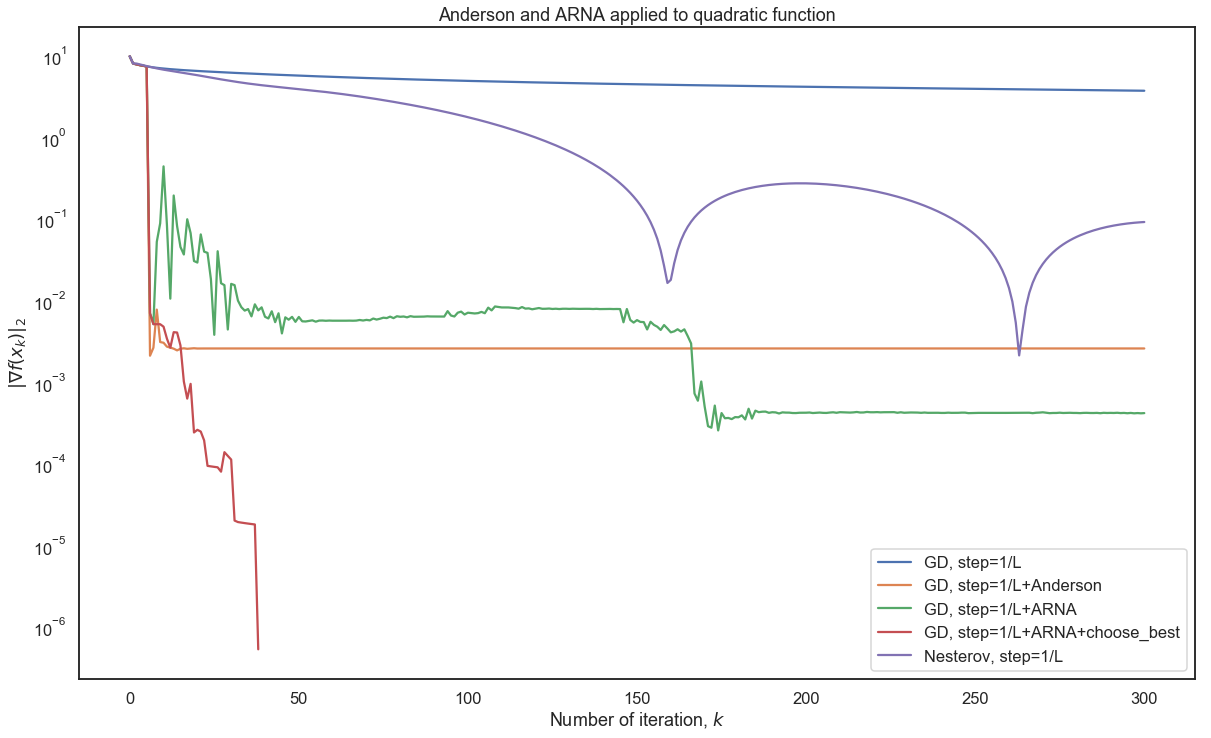

In [6]:
from liboptpy_acc import unconstr_solvers as solvers
from liboptpy_acc import step_size as ss


vals = np.linalg.eigvalsh(A)
opt_step = 1 / vals.max()

m_dict = {
     "GD, step=1/L": solvers.fo.GradientDescent(f1, grad_f1, ss.ConstantStepSize(opt_step)),
     "GD, step=1/L+Anderson": solvers.fo.GradientDescent(f1, grad_f1, ss.ConstantStepSize(opt_step),
                                                        accelerator=anderson),
     "GD, step=1/L+ARNA": solvers.fo.GradientDescent(f1, grad_f1, ss.ConstantStepSize(opt_step), accelerator=arna),
     "GD, step=1/L+ARNA+choose_best": solvers.fo.GradientDescent(f1, grad_f1, ss.ConstantStepSize(opt_step),
                                                                 accelerator=arna, choose_best=True),
     "Nesterov, step=1/L": solvers.fo.AcceleratedGD(f1, grad_f1, ss.ConstantStepSize(opt_step))
}

tol = 10**-6
max_iter=300
for key in m_dict:
    _ = m_dict[key].solve(x01, max_iter, tol)
    
plt.figure(figsize=(20, 12))
plt.title('Anderson and ARNA applied to quadratic function')
for key in m_dict:
    plt.semilogy([np.linalg.norm(grad_f1(x)) for x in m_dict[key].get_convergence()], label=key)
    plt.xlabel("Number of iteration, $k$")
plt.ylabel(r"$\| \nabla f(x_k)\|_2$")
plt.legend();

Здесь *choose_best* включает сравнение $f(x_{-1})$ и $f(x_{extr})$ на случай, если алгоритм ошибся.

## Ridge регрессия

Загрузим датасет:

In [7]:
from sklearn.datasets import load_boston

boston = load_boston()
Z = boston['data']
Z = np.hstack([np.ones((len(Z), 1)), Z]) # добавляем const столбец
y = boston['target'] * 2 - 1
x0 = np.zeros(Z.shape[1])

Вычислим константу Липшица для Ridge регрессии: 

$$
f(w) = \dfrac 1m\sum_{i=1}^m(Z_iw-y_i)^2+\dfrac \lambda2\|w\|_2^2,
$$

$$
\nabla f(w) =2\cdot Z^\mathsf{T}(Z_iw-y_i)\cdot Z_i^\mathsf{T}+\lambda w,
$$

$$
\nabla^2 f(w)=2Z^\mathsf{T}Z+\lambda I,\quad L=\|\nabla^2 f(w)\|_2
$$

In [8]:
tau = 1

def loss(w, tau=tau):
    return np.mean((Z.dot(w) - y)**2) + tau / 2 * np.linalg.norm(w)**2

def grad_loss(w, tau=tau):
    return 2 * Z.T.dot(Z.dot(w) - y) + tau * w

def hess_loss(w, tau=tau):
    return 2 * Z.T.dot(Z) + np.eye(len(w)) * tau

In [9]:
mu = tau
L = np.linalg.norm(hess_loss(x0))
L / mu

317664860.8254386

Получим эталонный результат:

In [10]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error as mse

model = Ridge(fit_intercept=False)
print('MSE =', mse(model.fit(Z, y).predict(Z), y))

MSE = 90.62205124680482


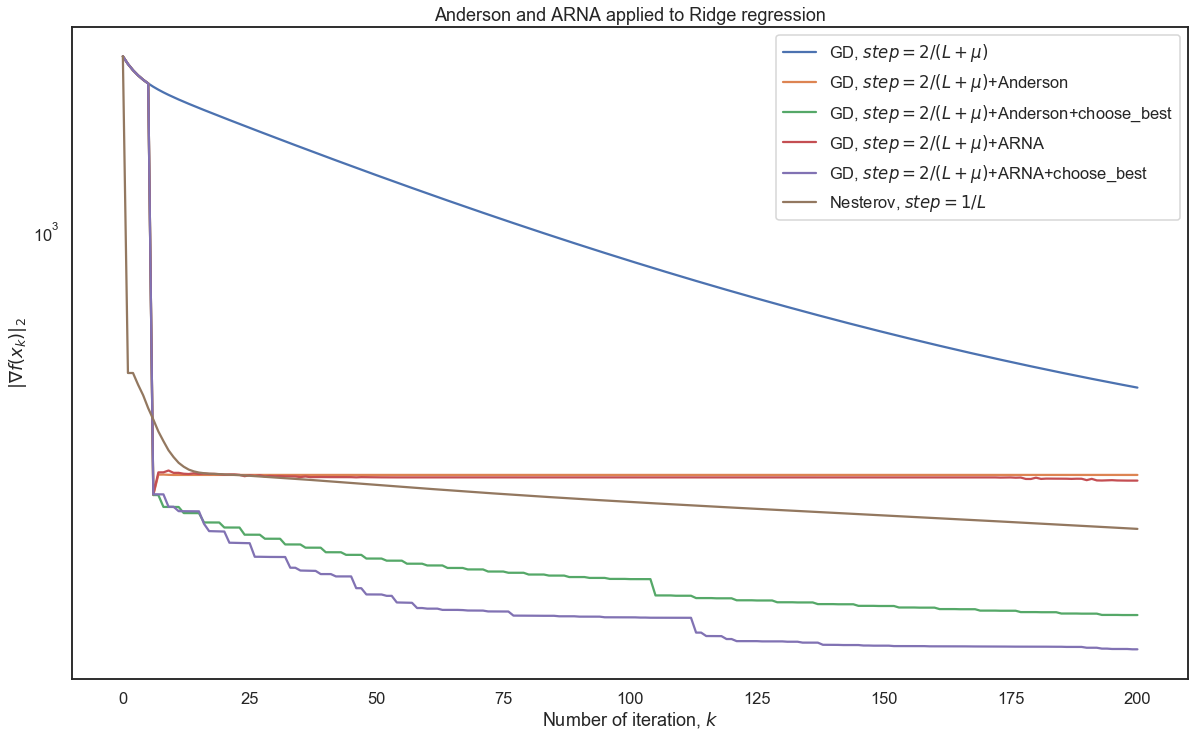

In [11]:
grad_step = 2 / (L + mu)
nest_step = 1 / L

m_dict = {
     r"GD, $step=2/(L+\mu)$": solvers.fo.GradientDescent(loss, grad_loss, ss.ConstantStepSize(grad_step)),
     r"GD, $step=2/(L+\mu)$+Anderson": solvers.fo.GradientDescent(loss, grad_loss, ss.ConstantStepSize(grad_step),
                                                                  accelerator=anderson),
     r"GD, $step=2/(L+\mu)$+Anderson+choose_best": solvers.fo.GradientDescent(loss, grad_loss,
                                                                              ss.ConstantStepSize(grad_step),
                                                                  accelerator=anderson, choose_best=True),
     r"GD, $step=2/(L+\mu)$+ARNA": solvers.fo.GradientDescent(loss, grad_loss, ss.ConstantStepSize(grad_step),
                                                              accelerator=arna),
     r"GD, $step=2/(L+\mu)$+ARNA+choose_best": solvers.fo.GradientDescent(loss, grad_loss,
                                                                          ss.ConstantStepSize(grad_step),
                                                                          accelerator=arna, choose_best=True),
     r"Nesterov, $step=1/L$": solvers.fo.AcceleratedGD(loss, grad_loss, ss.ConstantStepSize(nest_step))
}

tol = 10**-6
max_iter=200
for key in m_dict:
    _ = m_dict[key].solve(x0, max_iter, tol)
    
plt.figure(figsize=(20, 12))
plt.title('Anderson and ARNA applied to Ridge regression')
for key in m_dict:
    plt.semilogy([loss(x) for x in m_dict[key].get_convergence()], label=key)
    plt.xlabel("Number of iteration, $k$")
plt.ylabel(r"$\| \nabla f(x_k)\|_2$")
plt.legend();

In [12]:
keys = list(m_dict.keys())
mses = []
for key, alg in m_dict.items():
    coef = alg.get_convergence()[-1]
    mses.append(int(mse(Z.dot(coef), y)))

keys, mses = np.array(keys), np.array(mses)
keys = keys[mses.argsort()]
mses.sort()

for key, mse_val in zip(keys, mses):
    print(mse_val, '<-', key)

116 <- GD, $step=2/(L+\mu)$+ARNA+choose_best
159 <- GD, $step=2/(L+\mu)$+Anderson+choose_best
245 <- Nesterov, $step=1/L$
308 <- GD, $step=2/(L+\mu)$+ARNA
317 <- GD, $step=2/(L+\mu)$+Anderson
478 <- GD, $step=2/(L+\mu)$


## Метод второго порядка

Реализуем метод Ньютона:

In [13]:
def Newton(f, gradf, hessf, x0, epsilon, num_iter, line_search, disp=False, callback=None, accelerator=None, **kwargs):
    x = x0.copy()
    convergence = [x]
    iteration = 0
    opt_arg = {"f": f, "grad_f": gradf}
    for key in kwargs:
        opt_arg[key] = kwargs[key]
    while True:
        gradient = gradf(x)
        hess = hessf(x)
        try:
            h = np.linalg.solve(hess, -gradient)
        except Exception as e:
            print('Error:', e)
            break
        alpha = line_search(x, h, **opt_arg)
        x = x + alpha * h
        
        convergence.append(x)
        if accelerator is not None:
            x_extr = accelerator(convergence, f)
            if f(x_extr) < f(x):
                x = x_extr
        
        if callback is not None:
            callback(x)
        iteration += 1
        if disp:
            print("Current function val =", f(x))
            print("Current gradient norm = ", np.linalg.norm(gradf(x)))
        if np.linalg.norm(gradf(x)) < epsilon:
            break
        if iteration >= num_iter:
            break
    res = {"x": x, "num_iter": iteration, "tol": np.linalg.norm(gradf(x))}
    return res

Зададим функцию:

In [14]:
def f(x):
    return np.log(np.exp(x) + np.exp(-x))

def gradf(x):
    return (np.exp(x) - np.exp(-x)) / (np.exp(x) + np.exp(-x))

def hessf(x):
    return np.array(4 / (np.exp(x) + np.exp(-x))**2).reshape((1, 1))

x0 = np.array([100])

Сравним скорости сходимости обычного и ускоренного методов Ньютона:

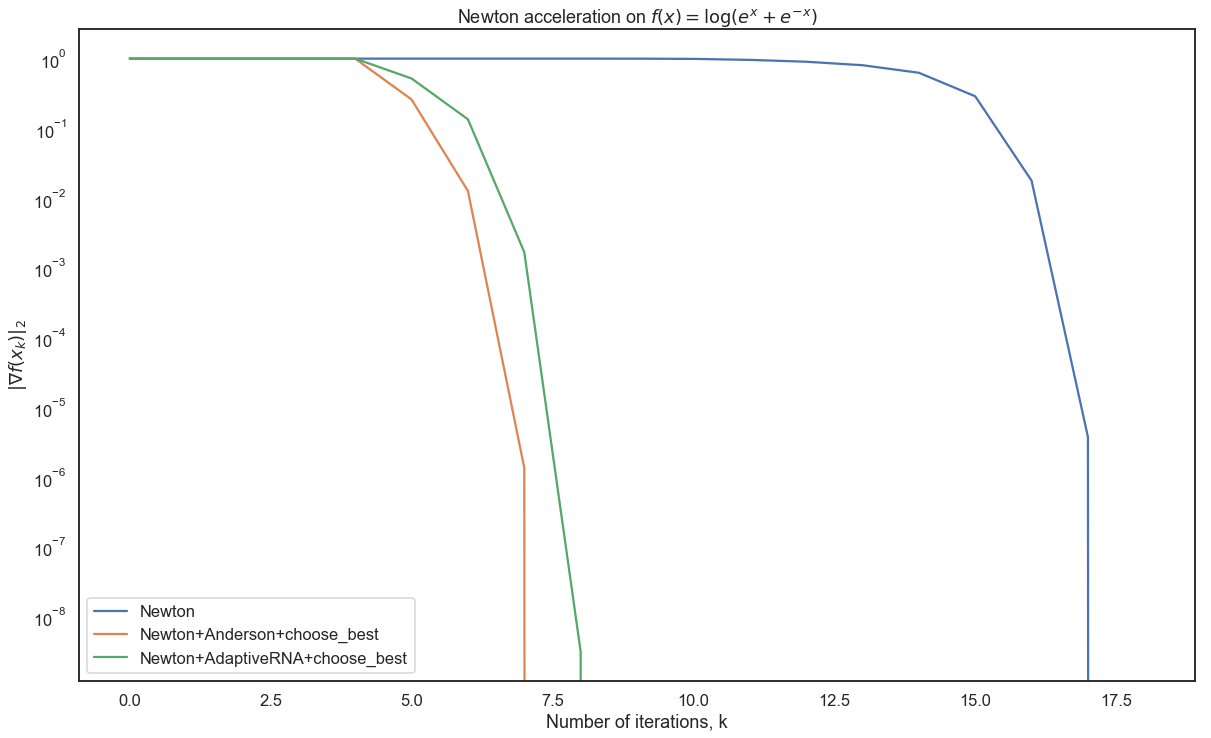

In [15]:
def armijo_step(x, h, **kwargs):
    f = kwargs['f']
    gradf = kwargs['grad_f']
    rho = kwargs['rho']
    beta = kwargs['beta']
    
    assert beta < 0.5, "Armijo rule is applicable for beta less than 0.5"
    assert rho < 1, "Decay factor has to be less than 1"
    
    alpha = 1
    x_next = x + alpha * h
    current_grad = gradf(x)
    current_f = f(x)
    while f(x_next) > current_f + beta * current_grad @ (x_next - x):
        alpha *= rho
        x_next = x + alpha * h
    return alpha

def compare_accelerators(optimizer, optimizer_lbl, params, accelerators):
    plt.figure(figsize=(20, 12))
    plt.title(optimizer_lbl + r' acceleration on $f(x)=\log(e^x+e^{-x})$')
    plt.xlabel('Number of iterations, k')
    plt.ylabel(r"$\| \nabla f(x_k)\|_2$")
    
    accelerators = [('', None)] + accelerators
    
    def callback(x):
        points.append(np.linalg.norm(params['gradf'](x)))
        
    for label, accelerator in accelerators:
        if label:
            label = optimizer_lbl + '+' + label
        else:
            label = optimizer_lbl
            
        points = []
        optimizer(**params, callback=callback, accelerator=accelerator)
        plt.semilogy(points, label=label)
    plt.legend()
    
np.seterr(all='ignore')
params = {'f': f, 'gradf': gradf, 'hessf': hessf, 'x0': np.array([100]), 'epsilon': 10**-12,
          'num_iter': 100, 'line_search': armijo_step, 'rho': 0.9, 'beta': 0.1}
accelerators = [('Anderson+choose_best', anderson), ('AdaptiveRNA+choose_best', arna)]
compare_accelerators(Newton, 'Newton', params, accelerators)